In [1]:
from model import *
from loader import train_loader, val_loader, test_loader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [10]:
model = UNet()
if torch.cuda.is_available():
    model = model.to('cuda')

In [11]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005) # weight_decay=

In [12]:
# Showing that the image names match up :)
# for i, sample in enumerate(train_loader):
#     Xs, Ys = sample["image"], sample["annotation"]
#     print("sz", len(Xs), len(Ys))
#     print(i, "batch 0 X, Y", Xs[0], Ys[0])
#     print(i, "batch 1 X, Y", Xs[1], Ys[1])
#     break

In [13]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
train_hist, val_hist = None, None

In [14]:
# Initialize weights randomly (prevents getting caught at starting loss and not moving)
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)
print("Weights initialized")

Weights initialized


In [15]:
def train(model, criterion, epochs = 5, verbose=False, train_hist=None, val_hist=None):
  if not train_hist:
    train_hist = []
  if not val_hist:
    val_hist = []
    
  torch.cuda.empty_cache()
    
  tqdm.write("====== Training Started ======")
  try:
    for e in tqdm(range(epochs), position=0, desc="Epochs", leave=False, colour='green'):
      train_running_loss = 0.0
      validation_running_loss = 0.0
      ct = 0.0
      
      model.train()
      
      # print("Losses are reset to:", train_running_loss, validation_running_loss, ct)
      for ith_batch, sample in tqdm(enumerate(train_loader), position=1, desc="Batches", leave=False, total=len(train_loader), colour='blue'):
        X, Y = sample['image'], sample['annotation']
      #   plt.imshow(pred.detach().numpy()[0].transpose(1, 2, 0))

        if torch.cuda.is_available():
          X = X.to('cuda')
          Y = Y.to('cuda')

        y_pred = model(X)
      # out = (y_pred + 0.5).int().float()
        
        loss = criterion(y_pred, Y) #* 0.70 + 0.30 * dice_loss(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose and ith_batch % 10 == 0 and ith_batch != 0:
          # print("This item's loss:", f'{loss.item()}')
          # print("This pred started with", y_pred[0][0][0][0:10])
          tqdm.write('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Curr Epoch Loss: ', f'{train_running_loss / ct:0.3f}')
          
        train_running_loss += loss.item()
        train_hist.append(loss.item())
        ct += 1.0
        
      with torch.no_grad():
        
        model.eval()
        
        for ith_batch, sample in enumerate(val_loader):
            X_val, y_val = sample['image'], sample['annotation']
            
            if torch.cuda.is_available():
              X_val = X_val.to('cuda')
              y_val = y_val.to('cuda')
            
            y_out = model(X_val)
            
            # print("Pred is", y_out[y_out.shape[0]//2,y_out.shape[1]//2-1:y_out.shape[1]//2+1])
            val_loss = criterion(y_out, y_val)

            validation_running_loss += val_loss.item()
            val_hist.append(val_loss.item())

      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(val_loader)
        
      if verbose:
        tqdm.write("================================================================================")
        tqdm.write("Epoch {} completed".format(e + 1))
        tqdm.write("Average train loss is {:0.3f}: ".format(train_epoch_loss))
        tqdm.write("Average validation loss is {:0.3f}".format(validation_epoch_loss))
        tqdm.write("================================================================================")
      else:
        tqdm.write(f"Epoch {e + 1}. Train Loss: {train_epoch_loss:0.4f} Val Loss: {validation_epoch_loss:0.4f}")
        
      torch.cuda.empty_cache()
  except Exception as e:
    print("Exception:", e)
    print("Halting training and returning historical loss data")
  return train_hist, val_hist

In [16]:
total_epochs=0

In [17]:
num_epochs = 50
# Including train_hist, val_hist in our parameters allows us to retain our previously saved loss data 
# and visualize the full training graph
train_hist, val_hist = train(model, criterion, epochs=num_epochs, verbose=False, train_hist=train_hist, val_hist=val_hist)
total_epochs+=num_epochs

====== Training Started ======


Epoch 1. Train Loss: 0.7565 Val Loss: 0.6932


Epoch 2. Train Loss: 0.6962 Val Loss: 0.6932


Epoch 3. Train Loss: 0.6936 Val Loss: 0.6932


Epoch 4. Train Loss: 0.6936 Val Loss: 0.6932


Epoch 5. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 6. Train Loss: 0.6934 Val Loss: 0.6932


Epoch 7. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 8. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 9. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 10. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 11. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 12. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 13. Train Loss: 0.6932 Val Loss: 0.6931


Epoch 14. Train Loss: 0.6932 Val Loss: 0.6931


KeyboardInterrupt: 

torch.Size([512, 512, 1])


ValueError: expected 4D input (got 3D input)

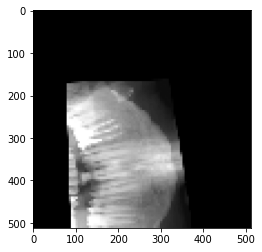

<Figure size 432x288 with 0 Axes>

In [29]:
for i, sample in enumerate(train_loader):
    Xs, Ys = sample["image"], sample["annotation"]
    Xs = Xs.to("cuda")
    Ys = Ys.to("cuda")
    print(np.transpose(Xs[0].cpu(), (2,1,0)).shape)
    plt.imshow(np.transpose(Xs[0].cpu(), (2,1,0)), cmap='gray')
    plt.figure()
    plt.imshow(np.transpose(model(Xs[0]), (2,1,0)), cmap='gray')
    plt.figure()
    plt.imshow(np.transpose(Ys[0], (2,1,0)), cmap='gray')
    break

In [32]:
torch.save(model.state_dict(), "models/best_UNet__512_512.pth")

In [ ]:
'''
Result: 06740_1600_1200
150 epochs @ 0.000001 LR
50 epochs @ 0.000005 LR


'''

'''
Weights initialized
Output exceeds the size limit. Open the full output data in a text editor
====== Training Started ======
Epoch 1. Train Loss: 0.689 Val Loss: 0.693
Epoch 2. Train Loss: 0.672 Val Loss: 0.668
Epoch 3. Train Loss: 0.663 Val Loss: 0.658
Epoch 4. Train Loss: 0.659 Val Loss: 0.671
Epoch 5. Train Loss: 0.656 Val Loss: 0.657
Epoch 6. Train Loss: 0.651 Val Loss: 0.657
Epoch 7. Train Loss: 0.649 Val Loss: 0.654
Epoch 8. Train Loss: 0.648 Val Loss: 0.650
Epoch 9. Train Loss: 0.648 Val Loss: 0.652
Epoch 10. Train Loss: 0.646 Val Loss: 0.650
Epoch 11. Train Loss: 0.642 Val Loss: 0.665
Epoch 12. Train Loss: 0.641 Val Loss: 0.649
Epoch 13. Train Loss: 0.641 Val Loss: 0.640
Epoch 14. Train Loss: 0.638 Val Loss: 0.641
Epoch 15. Train Loss: 0.637 Val Loss: 0.638
Epoch 16. Train Loss: 0.630 Val Loss: 0.636
Epoch 17. Train Loss: 0.627 Val Loss: 0.630
Epoch 18. Train Loss: 0.624 Val Loss: 0.631
Epoch 19. Train Loss: 0.625 Val Loss: 0.626
Epoch 20. Train Loss: 0.620 Val Loss: 0.620
Epoch 21. Train Loss: 0.618 Val Loss: 0.621
Epoch 22. Train Loss: 0.632 Val Loss: 0.634
Epoch 23. Train Loss: 0.620 Val Loss: 0.627
Epoch 24. Train Loss: 0.616 Val Loss: 0.618
...
Epoch 47. Train Loss: 0.593 Val Loss: 0.606
Epoch 48. Train Loss: 0.591 Val Loss: 0.603
Epoch 49. Train Loss: 0.592 Val Loss: 0.602
Epoch 50. Train Loss: 0.591 Val Loss: 0.603
'''

In [27]:
def plot_loss(title="Without Data Augmentation", ylabel="BCE Loss", xlabel="Epochs"):
    train_means, val_means = [], []
    for i in range(total_epochs):
        train_means.append(np.mean(train_hist[len(train_loader)*i:len(train_loader)*(i+1)]))
        val_means.append(np.mean(val_hist[len(val_loader)*i:len(val_loader)*(i+1)]))
    plt.plot(train_means, label = 'Train Loss')
    plt.plot(val_means, label = 'Validation Loss')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

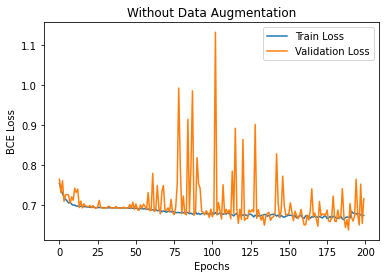

In [31]:
plot_loss()

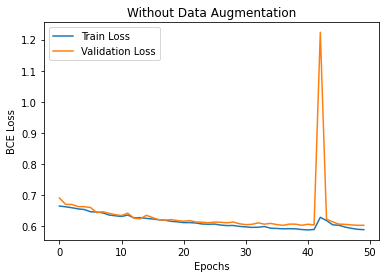

In [ ]:
# plot_loss()

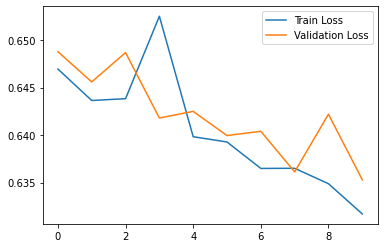

In [ ]:
# plot_loss()